 # Precision of R11G11B10F.
 The following graphs demonstrate the precision of R11G11B10F texture in a great blog post ["Small float formats – R11G11B10F precision"](https://bartwronski.com/2017/04/02/small-float-formats-r11g11b10f-precision/) by Bartłomiej Wroński. The original graphs are drawn by Mathematica, and here is my implementation by using NumPy and Matplotlib.

In [214]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
plot_style = {'alpha': 0.7}

def srgb_to_linear(x):
    # y = x.copy()
    # mask = x < 0.04045
    # y[mask] /= 12.92
    # y[~mask] = np.power((x[~mask] + 0.055) / 1.055, 2.4)
    # return y
    return np.where(x < 0.04045, x / 12.92, ((x + 0.055) / 1.055) ** 2.4)

def linear_to_srgb(x):
    return np.where(x < 0.0031308, 12.92 * x, 1.055 * np.power(x, 1/2.4) - 0.055)

def as_linear8(x):
    return np.around(x * 255) / 255

def as_srgb8(x):
    # 8-bit linear quantization of sRGB encoded value first, then convert back to linear domain.
    return srgb_to_linear(as_linear8(linear_to_srgb(x)))

def as_float_x(x, exponent_bit_count, mantissa_bit_count):
    """
    Modify mantissa and exponent number to convert float with given bit count.
    """
    m, e = np.frexp(x)
    m *= 2
    e -= 1

    max_exponent = 1 << (exponent_bit_count - 1)
    min_exponent = -(max_exponent - 1) - mantissa_bit_count # Includes subnormal range

    overflow_mask = e >= max_exponent
    e[overflow_mask] = -1
    m[overflow_mask] = float('inf')
    
    subnormal_mask = e < min_exponent
    m[subnormal_mask] = 0.0
    e[subnormal_mask] = 0.0    # Less than the subnormals.
    
    round_scale = 1 << mantissa_bit_count
    m[~subnormal_mask] = np.around(m[~subnormal_mask] * round_scale) / round_scale   # Truncate mantissa
    
    return m * (2.0 ** e)

def as_float16(x):
    return as_float_x(x, 5, 10)

def as_float10(x):
    return as_float_x(x, 5, 5)

def as_float11(x):
    return as_float_x(x, 5, 6)



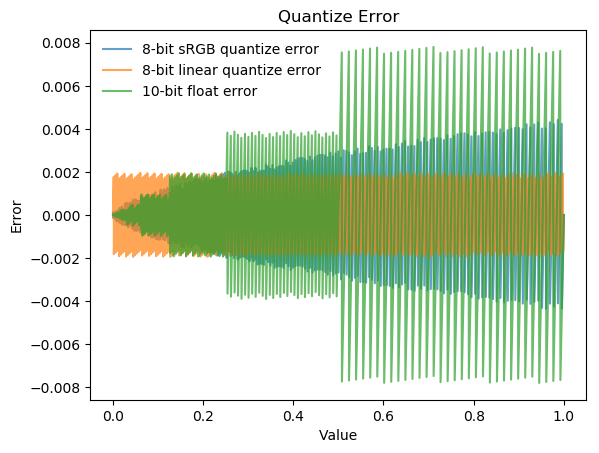

In [215]:
x = np.linspace(0.0001, 1.0, 3000)
y8 = x - as_linear8(x)
y8srgb = x - as_srgb8(x)
y10f = x - as_float10(x)
plt.title('Quantize Error')
plt.xlabel('Value')
plt.ylabel('Error')
plt.plot(x, y8srgb, label='8-bit sRGB quantize error', **plot_style)
plt.plot(x, y8, label='8-bit linear quantize error', **plot_style)
plt.plot(x, y10f, label='10-bit float error', **plot_style)
plt.legend(loc='upper left', frameon=False)
plt.show()


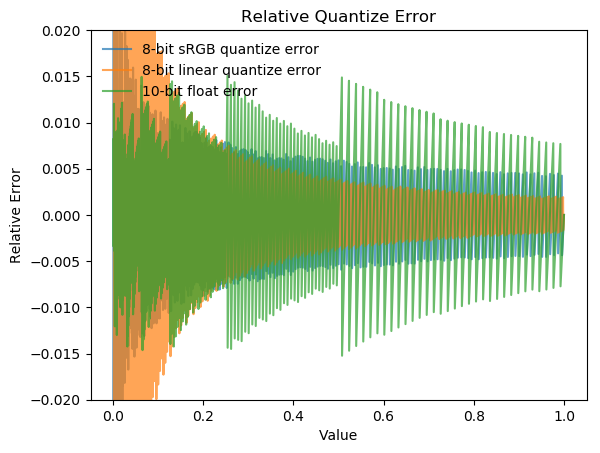

In [216]:
# Display with relative error.
plt.ylim(-0.02, 0.02)
plt.title('Relative Quantize Error')
plt.xlabel('Value')
plt.ylabel('Relative Error')
plt.plot(x, y8srgb / x, label='8-bit sRGB quantize error', **plot_style)
plt.plot(x, y8 / x, label='8-bit linear quantize error', **plot_style)
plt.plot(x, y10f / x, label='10-bit float error', **plot_style)
plt.legend(loc='upper left', frameon=False)
plt.show()



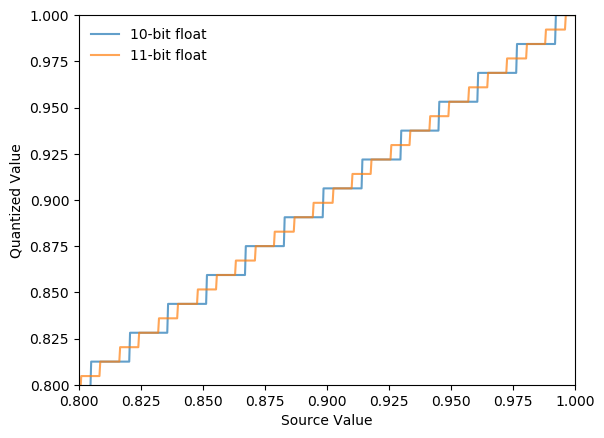

In [217]:
plt.xlim(0.8, 1.0)
plt.ylim(0.8, 1.0)
plt.xlabel('Source Value')
plt.ylabel('Quantized Value')
plt.plot(x, as_float10(x), label='10-bit float', **plot_style)
plt.plot(x, as_float11(x), label='11-bit float', **plot_style)
plt.legend(loc='upper left', frameon=False)
plt.show()



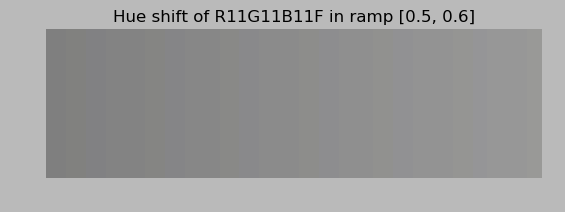

In [218]:
x = np.linspace(0.5, 0.6, 100)
c = np.repeat(x, 5)
f10 = as_float10(c)
f11 = as_float11(c)
color_ramp = np.vstack((f11, f11, f10)).transpose()
img = np.ones((150, 1, 1)) * color_ramp

fig = plt.figure()
fig.patch.set_facecolor((0.73, 0.73, 0.73))
plt.title('Hue shift of R11G11B11F in ramp [0.5, 0.6]')
plt.axis('off')
plt.imshow(img)



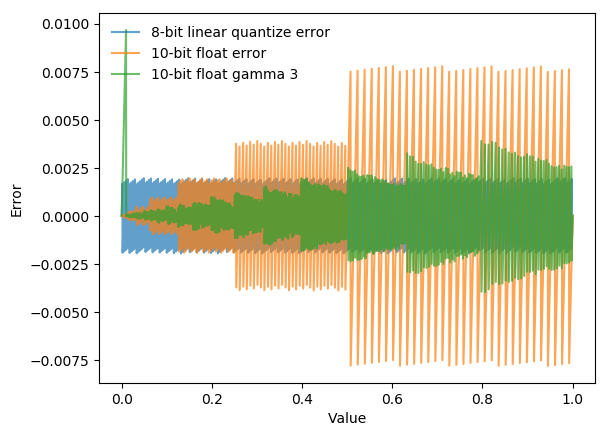

In [219]:
# Apply power 3 to put more bits on highlight instead of shadow.
# This could be seen as the opposite of gamma 1/2.2.
x = np.linspace(0.0, 1.0, 3000)
y8 = x - as_linear8(x)
y10f = x - as_float10(x)
y10f3 = x - as_float10(x ** 3.0) ** (1.0 / 3.0)
plt.xlabel('Value')
plt.ylabel('Error')
plt.plot(x, y8, label='8-bit linear quantize error', **plot_style)
plt.plot(x, y10f, label='10-bit float error', **plot_style)
plt.plot(x, y10f3, label='10-bit float gamma 3', **plot_style)
plt.legend(loc='upper left', frameon=False)
plt.show()


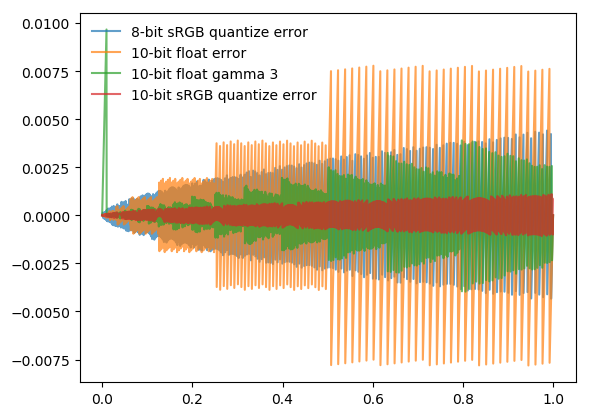

In [220]:
def as_linear10(x):
    return np.around(x * 1024) / 1024

def as_srgb10(x):
    # 8-bit linear quantization of sRGB encoded value first, then convert back to linear domain.
    return srgb_to_linear(as_linear10(linear_to_srgb(x)))

y8srgb = x - as_srgb8(x)
y10srgb = x - as_srgb10(x)
y10f = x - as_float10(x)
y10f3 = x - as_float10(x ** 3.0) ** (1.0 / 3.0)
plt.plot(x, y8srgb, label='8-bit sRGB quantize error', **plot_style)
plt.plot(x, y10f, label='10-bit float error', **plot_style)
plt.plot(x, y10f3, label='10-bit float gamma 3', **plot_style)
plt.plot(x, y10srgb, label='10-bit sRGB quantize error', **plot_style)
plt.legend(loc='upper left', frameon=False)
plt.show()


 There is a spike in 10-bit float gamma 3 when x <= 0.00966989.

 ```x[y10f3 / x > 0.99]```

 array([0.00033344, 0.00066689, 0.00100033, 0.00133378, 0.00166722,
        0.00200067, 0.00233411, 0.00266756, 0.003001  , 0.00333444,
        0.00366789, 0.00400133, 0.00433478, 0.00466822, 0.00500167,
        0.00533511, 0.00566856, 0.006002  , 0.00633545, 0.00666889,
        0.00700233, 0.00733578, 0.00766922, 0.00800267, 0.00833611,
        0.00866956, 0.009003  , 0.00933645, 0.00966989])

 Their cubed can't represented by subnormals of 10-bit float whose minimum is 0.0000019073486328125.

 array([3.70740988e-11, 2.96592790e-10, 1.00100067e-09, 2.37274232e-09,
        4.63426235e-09, 8.00800534e-09, 1.27164159e-08, 1.89819386e-08,
        2.70270180e-08, 3.70740988e-08, 4.93456255e-08, 6.40640427e-08,
        8.14517950e-08, 1.01731327e-07, 1.25125083e-07, 1.51855509e-07,
        1.82145047e-07, 2.16216144e-07, 2.54291244e-07, 2.96592790e-07,
        3.43343229e-07, 3.94765004e-07, 4.51080560e-07, 5.12512342e-07,
        5.79282793e-07, 6.51614360e-07, 7.29729486e-07, 8.13850616e-07,
        9.04200195e-07])

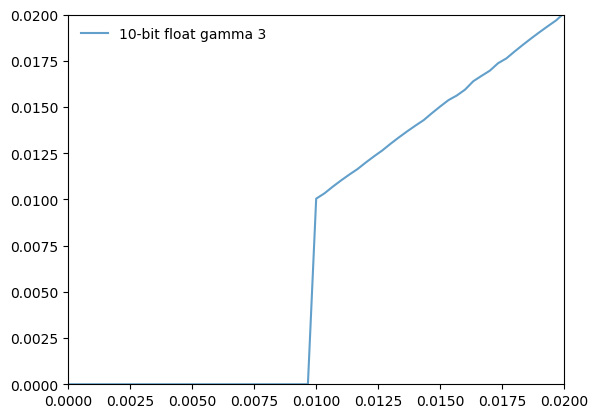

In [221]:
plt.xlim(0, 0.02)
plt.ylim(0, 0.02)
plt.plot(x, as_float10(x ** 3.0) ** (1.0 / 3.0), label='10-bit float gamma 3', **plot_style)
plt.legend(loc='upper left', frameon=False)
plt.show()


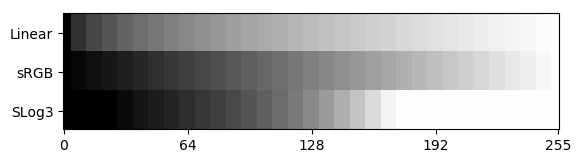

In [222]:
def ramp_to_image(x, height=20):
    scalar_img = (np.ones((height, 1)) * x)
    return np.clip(scalar_img[..., np.newaxis], 0.0, 1.0) * np.ones(3)

def linear_map(x, segment_num):
    return np.around(x * segment_num) / segment_num

def cineon_log_to_linear(x):
    return (np.power(10, (1023 * x -685) / 300) - 0.0108) / (1.0 - 0.0108)

def sony_slog3_to_linear(x):
    # https://github.com/ampas/aces-dev/blob/master/transforms/ctl/idt/vendorSupplied/sony/IDT.Sony.SLog3_SGamut3.ctl
    return np.where(x >= 171.2102946929 / 1023.0, 
        np.power(10.0, (x*1023.0-420.0)/261.5)*(0.18+0.01)-0.01,
        (x*1023.0-95.0)*0.01125000/(171.2102946929-95.0))

x = np.linspace(0.0, 1.0, 256)
l = linear_map(x, 32)

img_linear = ramp_to_image(l)
img_srgb = ramp_to_image(srgb_to_linear(l)) # Evenly distribute levels on sRGB curve.
img_log =ramp_to_image(cineon_log_to_linear(l))

I = np.vstack((img_linear, img_srgb, img_log))

# Add annotation
fig, ax = plt.subplots()
x_ticks = [0, 64, 128, 192, 255]
ax.set_xticks(x_ticks)
ax.set_yticklabels(x_ticks)
ax.set_yticks(np.arange(3) * 20 + 10)
ax.set_yticklabels(['Linear', 'sRGB', 'SLog3'])
plt.imshow(linear_to_srgb(I))
plt.show()


 # Building a Tonemapper
 [Timothy Lottes](https://gpuopen.com/author/tlottes/) has shared wonderful slides about the design of tone mapper curve in the presentation ["Advanced Techniques and Optimization of VDR Color Pipelines"](https://32ipi028l5q82yhj72224m8j-wpengine.netdna-ssl.com/wp-content/uploads/2016/03/GdcVdrLottes.pdf) p.39. Here is step-by-step progress:

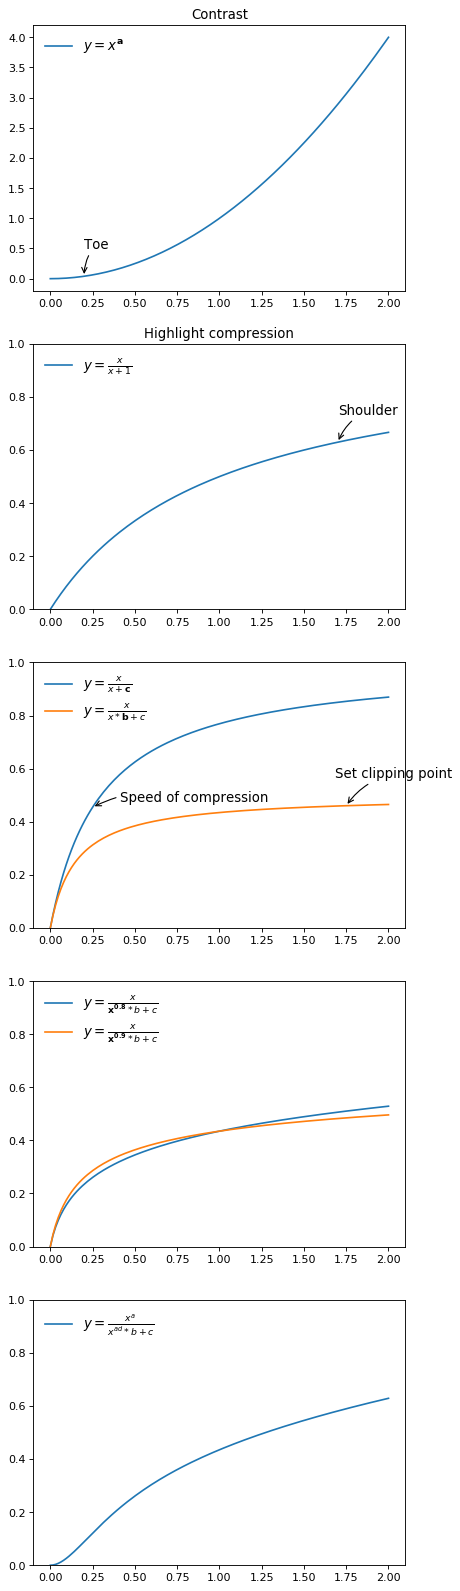

In [223]:
plt.figure(figsize=(6, 25), dpi=80)
x = np.linspace(0, 2, 128)

t = 0.2
f = lambda x : np.power(x, 2)
plt.subplot(5, 1, 1)
plt.title('Contrast')
plt.plot(x, f(x), label=r'$y=x^{\mathbf{a}}$')
plt.annotate('Toe', xy=(t, f(t)),
             xytext=(0, +25), textcoords='offset points', fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.legend(loc='upper left', frameon=False, prop={'size': 12})

plt.subplot(5, 1, 2)
t = 1.7
f = lambda x : x / (x + 1)
plt.ylim(0.0, 1.0)
plt.title('Highlight compression')
plt.plot(x, f(x), label=r'$y=\frac{x}{x + 1}$')
plt.annotate('Shoulder', xy=(t, f(t)),
             xytext=(0, +25), textcoords='offset points', fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.legend(loc='upper left', frameon=False, prop={'size': 12})

plt.subplot(5, 1, 3)
plt.ylim(0.0, 1.0)
t = 0.25
f = lambda x : x / (x + 0.3)
plt.plot(x, f(x), label=r'$y=\frac{x}{x + \mathbf{c}}$')
plt.annotate('Speed of compression', xy=(t, f(t)),
             xytext=(25, 5), textcoords='offset points', fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

t = 1.75
f = lambda x : x / (x * 2 + 0.3)
plt.plot(x, f(x), label=r'$y=\frac{x}{x * \mathbf{b} + c}$')
plt.annotate('Set clipping point', xy=(t, f(t)),
             xytext=(-10, +25), textcoords='offset points', fontsize=12,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.legend(loc='upper left', frameon=False, prop={'size': 12})


plt.subplot(5, 1, 4)
plt.ylim(0.0, 1.0)
f = lambda x, d: x / (np.power(x, d) * 2 + 0.3)
plt.plot(x, f(x, 0.8), label=r'$y=\frac{x}{ \mathbf{x^{0.8}} * b + c}$')
plt.plot(x, f(x, 0.9), label=r'$y=\frac{x}{ \mathbf{x^{0.9}} * b + c}$')
plt.legend(loc='upper left', frameon=False, prop={'size': 12})

def tone_curve(x, a, b, c, d):
    z = np.power(x, a)
    return z / (np.power(z, d) * b + c)

plt.subplot(5, 1, 5)
plt.ylim(0.0, 1.0)
tc = tone_curve(x, 2, 2, 0.3, 0.8)
plt.plot(x, tc, label=r'$y=\frac{x^a}{x^{ad} * b + c}$')
plt.legend(loc='upper left', frameon=False, prop={'size': 12})


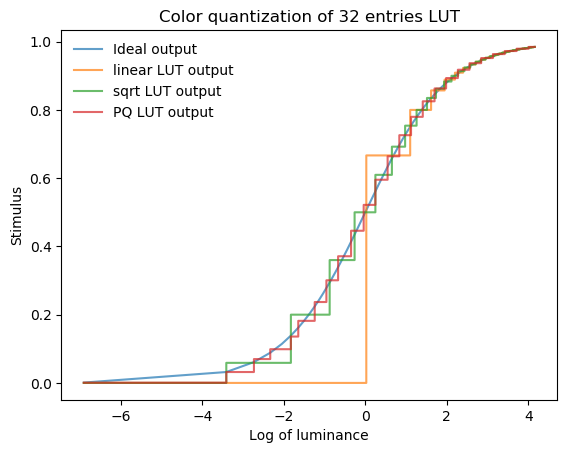

In [224]:
def tonemap(x):
    return x / (x + 1.0)

def slice_32(x):
    # Input should be in [0, 1]
    return np.around(x * 32) / 32

def linear_to_PQ(x):
    # https://en.wikipedia.org/wiki/High-dynamic-range_video#Perceptual_Quantizer
    m1 = 0.1593017578125
    m2 = 78.84375
    c1 = 0.8359375
    c2 = 18.8515625
    c3 = 18.6875
    p = np.power(x, m1)
    return np.power((c1 + c2 * p) / (1.0 + c3 * p), m2)

def PQ_to_linear(x):
    m1 = 0.1593017578125
    m2 = 78.84375
    c1 = 0.8359375
    c2 = 18.8515625
    c3 = 18.6875
    p = np.power(x, 1.0 / m2)
    return np.power(np.maximum(p - c1, 0.0) / (c2 - c3 * p), 1.0 / m1)

x = np.linspace(0.001, 64, 2000)
xs = np.log(x)
y = (tonemap(x))

y_linear = (tonemap(slice_32(x / 64) * 64))
y_sqrt = (tonemap(slice_32(np.sqrt(x / 64)) ** 2 * 64))
y_pq = (tonemap(PQ_to_linear(slice_32(linear_to_PQ(x / 64))) * 64))
plt.title('Color quantization of 32 entries LUT')
plt.xlabel('Log of luminance')
plt.ylabel('Stimulus')
plt.plot(xs, y, label='Ideal output', **plot_style)
plt.plot(xs, y_linear, drawstyle='steps-post', label='linear LUT output', **plot_style)
plt.plot(xs, y_sqrt, drawstyle='steps-post', label='sqrt LUT output', **plot_style)
plt.plot(xs, y_pq, drawstyle='steps-post', label='PQ LUT output', **plot_style)
plt.legend(loc='upper left', frameon=False)
plt.show()
